<a href="https://colab.research.google.com/github/yankyerajoseph/yankyerajoseph/blob/main/Appendix_5_New_Codes_for_Hybrid_Models_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Task
# Apply a million iterations to combine the first-order, modified Gompertz, and logistic growth models to create extremely good hybrid models for the 'HM' and 'NHMM' datasets. Select the best seven (7) hybrid models based on evaluation metrics and present their parameters, equations, and metrics. Ensure the simulation is robust enough to yield consistent results over a million iterations.

# Define the combined hybrid model function
# Subtask:
# Create a Python function that represents the combined hybrid model, taking parameters from all three individual models (First-Order, Modified Gompertz, and Logistic Growth).

# Reasoning: Define a Python function for the combined hybrid model as requested in the instructions.


def combined_hybrid_model(t, B0_fo, k_fo, B0_g, Rm_g, lambda_g, B0_lg, Rm_lg, lambda_lg, w_fo, w_g):
    """
    Combines the First-Order, Modified Gompertz, and Logistic Growth models with weightings.
    The weight for the Logistic Growth model is calculated as 1 - w_fo - w_g.

    Args:
        t (numpy.ndarray): Time or HRT values.
        B0_fo (float): Maximum biogas potential for the First-Order model.
        k_fo (float): Rate constant for the First-Order model.
        B0_g (float): Maximum biogas potential for the Gompertz model.
        Rm_g (float): Maximum specific biogas production rate for the Gompertz model.
        lambda_g (float): Lag phase duration for the Gompertz model.
        B0_lg (float): Maximum biogas potential for the Logistic Growth model.
        Rm_lg (float): Maximum specific biogas production rate for the Logistic Growth model.
        lambda_lg (float): Lag phase duration for the Logistic Growth model.
        w_fo (float): Weighting for the First-Order model.
        w_g (float): Weighting for the Gompertz model.

    Returns:
        numpy.ndarray: Weighted combined biogas yield.
    """
    # Ensure weights are positive and their sum is not greater than 1
    w_fo = max(0, w_fo)
    w_g = max(0, w_g)
    w_lg = max(0, 1 - w_fo - w_g)
    total_weight = w_fo + w_g + w_lg
    if total_weight > 0:
      scale = 1.0 / total_weight
      w_fo *= scale
      w_g *= scale
      w_lg *= scale
    else:
      w_fo = w_g = w_lg = 1/3


    first_order = B0_fo * (1 - np.exp(-k_fo * t))
    gompertz = B0_g * np.exp(-np.exp((Rm_g * np.e / B0_g) * (lambda_g - t) + 1))
    logistic_growth = B0_lg / (1 + np.exp((4 * Rm_lg / B0_lg) * (lambda_lg - t) + 2))

    # Apply weightings
    combined_yield = (w_fo * first_order + w_g * gompertz + w_lg * logistic_growth)

    return combined_yield

# Fit the combined model to the data
# Subtask:
# Use scipy.optimize.curve_fit to fit the combined model to the 'HM' and 'NHMM' datasets with a high maxfev value (one million as requested) and explore different initial guesses or bounds to find multiple good fits.

# Reasoning: Load the data, define the combined hybrid model, set up bounds and initial guesses, and iterate through initial guesses to fit the model for both 'HM' and 'NHMM' datasets, handling potential errors.


import numpy as np
from scipy.optimize import curve_fit, OptimizeWarning
import pandas as pd
from google.colab import drive
import warnings

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
file_path = '/content/drive/MyDrive/SummaryofBY/HMNHMMetal.csv'

# Load the data from the CSV file
data = pd.read_csv(file_path)

# Extract data for HM and NHMM
t_data = data[' HRT (d) '].values
B_data_hm = data[' HM (ml/g oTS) '].values
B_data_nhmm = data[' NHMM (ml/g oTS) '].values

# Define the combined hybrid model function with weightings
def combined_hybrid_model(t, B0_fo, k_fo, B0_g, Rm_g, lambda_g, B0_lg, Rm_lg, lambda_lg, w_fo, w_g):
    """
    Combines the First-Order, Modified Gompertz, and Logistic Growth models with weightings.
    The weight for the Logistic Growth model is calculated as 1 - w_fo - w_g.

    Args:
        t (numpy.ndarray): Time or HRT values.
        B0_fo (float): Maximum biogas potential for the First-Order model.
        k_fo (float): Rate constant for the First-Order model.
        B0_g (float): Maximum biogas potential for the Gompertz model.
        Rm_g (float): Maximum specific biogas production rate for the Gompertz model.
        lambda_g (float): Lag phase duration for the Gompertz model.
        B0_lg (float): Maximum biogas potential for the Logistic Growth model.
        Rm_lg (float): Maximum specific biogas production rate for the Logistic Growth model.
        lambda_lg (float): Lag phase duration for the Logistic Growth model.
        w_fo (float): Weighting for the First-Order model.
        w_g (float): Weighting for the Gompertz model.

    Returns:
        numpy.ndarray: Weighted combined biogas yield.
    """
    # Ensure weights are positive and their sum is not greater than 1
    w_fo = max(0, w_fo)
    w_g = max(0, w_g)
    w_lg = max(0, 1 - w_fo - w_g)
    total_weight = w_fo + w_g + w_lg
    if total_weight > 0:
      scale = 1.0 / total_weight
      w_fo *= scale
      w_g *= scale
      w_lg *= scale
    else:
      w_fo = w_g = w_lg = 1/3


    first_order = B0_fo * (1 - np.exp(-k_fo * t))
    gompertz = B0_g * np.exp(-np.exp((Rm_g * np.e / B0_g) * (lambda_g - t) + 1))
    logistic_growth = B0_lg / (1 + np.exp((4 * Rm_lg / B0_lg) * (lambda_lg - t) + 2))

    # Apply weightings
    combined_yield = (w_fo * first_order + w_g * gompertz + w_lg * logistic_growth)

    return combined_yield

# Define bounds for the parameters (8 original parameters + 2 for weightings)
lower_bounds = [0] * 10
upper_bounds = [np.inf] * 8 + [1] * 2 # Upper bounds for weightings are 1

# Generate diverse initial guesses (example: 20 different guesses)
# These are just examples, you should refine them based on your data characteristics
initial_guesses = []
for _ in range(20):
    guess = [
        np.random.uniform(300, 700),  # B0_fo
        np.random.uniform(0.05, 0.5), # k_fo
        np.random.uniform(300, 700),  # B0_g
        np.random.uniform(10, 150),   # Rm_g
        np.random.uniform(0, 5),      # lambda_g
        np.random.uniform(300, 700),  # B0_lg
        np.random.uniform(10, 150),   # Rm_lg
        np.random.uniform(0, 5),      # lambda_lg
        np.random.uniform(0, 1),      # w_fo
        np.random.uniform(0, 1)       # w_g
    ]
    initial_guesses.append(guess)

# Store successful fits for HM and NHMM
successful_fits_hm = []
successful_fits_nhmm = []

# Iterate through initial guesses and fit the model for HM
print("Fitting combined hybrid model for HM...")
for i, guess in enumerate(initial_guesses):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('error', category=RuntimeWarning)
            popt_hm, pcov_hm = curve_fit(combined_hybrid_model, t_data, B_data_hm, p0=guess, bounds=(lower_bounds, upper_bounds), maxfev=1000000)
            if pcov_hm is not None:
                successful_fits_hm.append({'popt': popt_hm, 'pcov': pcov_hm, 'initial_guess': guess})
        print(f"  HM Fit {i+1}: Successful")
    except (RuntimeError, OptimizeWarning) as e:
        print(f"  HM Fit {i+1}: Failed - {e}")
    except Exception as e:
        print(f"  HM Fit {i+1}: Failed - {e}")


# Iterate through initial guesses and fit the model for NHMM
print("\nFitting combined hybrid model for NHMM...")
for i, guess in enumerate(initial_guesses):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('error', category=RuntimeWarning)
            popt_nhmm, pcov_nhmm = curve_fit(combined_hybrid_model, t_data, B_data_nhmm, p0=guess, bounds=(lower_bounds, upper_bounds), maxfev=1000000)
            if pcov_nhmm is not None:
                successful_fits_nhmm.append({'popt': popt_nhmm, 'pcov': pcov_nhmm, 'initial_guess': guess})
        print(f"  NHMM Fit {i+1}: Successful")
    except (RuntimeError, OptimizeWarning) as e:
        print(f"  NHMM Fit {i+1}: Failed - {e}")
    except Exception as e:
        print(f"  NHMM Fit {i+1}: Failed - {e}")

print(f"\nFound {len(successful_fits_hm)} successful fits for HM.")
print(f"Found {len(successful_fits_nhmm)} successful fits for NHMM.")

from sklearn.metrics import r2_score, mean_squared_error

# Evaluate successful fits for HM
evaluated_fits_hm = []
for fit in successful_fits_hm:
    popt = fit['popt']
    B_pred_hm = combined_hybrid_model(t_data, *popt)
    r2 = r2_score(B_data_hm, B_pred_hm)
    rmse = np.sqrt(mean_squared_error(B_data_hm, B_pred_hm))
    evaluated_fits_hm.append({'popt': popt, 'r2': r2, 'rmse': rmse, 'initial_guess': fit['initial_guess']})

# Sort successful fits for HM by R-squared (descending) and then RMSE (ascending)
evaluated_fits_hm.sort(key=lambda x: (-x['r2'], x['rmse']))

# Select the best 7 fits for HM
best_fits_hm = evaluated_fits_hm[:7]


print("\nBest 7 fits for HM:")
for i, fit in enumerate(best_fits_hm):
    print(f"Fit {i+1}: R-squared = {fit['r2']:.4f}, RMSE = {fit['rmse']:.4f}")
    print(f"  Parameters: {fit['popt']}")


# Function to generate the equation string for the combined hybrid model
def get_combined_hybrid_equation(params):
    """
    Generates the equation string for the combined hybrid model.

    Args:
        params (list or np.ndarray): List or array of the 10 model parameters
                                      (B0_fo, k_fo, B0_g, Rm_g, lambda_g, B0_lg, Rm_lg, lambda_lg, w_fo, w_g).

    Returns:
        str: String representation of the combined hybrid model equation.
    """
    B0_fo, k_fo, B0_g, Rm_g, lambda_g, B0_lg, Rm_lg, lambda_lg, w_fo, w_g = params
    w_lg = 1 - w_fo - w_g # Calculate w_lg from the weights

    equation = (
        f"B(t) = ({w_fo:.4f} * {B0_fo:.4f} * (1 - exp(-{k_fo:.4f} * t))) + "
        f"({w_g:.4f} * {B0_g:.4f} * exp(-exp(({Rm_g:.4f} * {np.e:.4f} / {B0_g:.4f}) * ({lambda_g:.4f} - t) + 1))) + "
        f"({w_lg:.4f} * {B0_lg:.4f} / (1 + exp((4 * {Rm_lg:.4f} / {B0_lg:.4f}) * ({lambda_lg:.4f} - t) + 2)))"
    )
    return equation


# Present the best 7 fits for HM
print("--- Best 7 Combined Hybrid Model Fits for HM ---")
for i, fit in enumerate(best_fits_hm):
    print(f"\nFit {i+1}:")
    print(f"  Equation: {get_combined_hybrid_equation(fit['popt'])}")


print("--- Summary of Best 7 Combined Hybrid Model Fits for HM ---")
for i, fit in enumerate(best_fits_hm):
    print(f"\nFit {i+1}:")
    print(f"  R-squared: {fit['r2']:.4f}")
    print(f"  RMSE: {fit['rmse']:.4f}")

# Evaluate successful fits for NHMM
evaluated_fits_nhmm = []
for fit in successful_fits_nhmm:
    popt = fit['popt']
    B_pred_nhmm = combined_hybrid_model(t_data, *popt)
    r2 = r2_score(B_data_nhmm, B_pred_nhmm)
    rmse = np.sqrt(mean_squared_error(B_data_nhmm, B_pred_nhmm))
    evaluated_fits_nhmm.append({'popt': popt, 'r2': r2, 'rmse': rmse, 'initial_guess': fit['initial_guess']})

# Sort successful fits for NHMM by R-squared (descending) and then RMSE (ascending)
evaluated_fits_nhmm.sort(key=lambda x: (-x['r2'], x['rmse']))

# Select the best 7 fits for NHMM
best_fits_nhmm = evaluated_fits_nhmm[:7]


print("\nBest 7 fits for NHMM:")
for i, fit in enumerate(best_fits_nhmm):
    print(f"Fit {i+1}: R-squared = {fit['r2']:.4f}, RMSE = {fit['rmse']:.4f}")
    print(f"  Parameters: {fit['popt']}")

# Present the best 7 fits for NHMM
print("--- Best 7 Combined Hybrid Model Fits for NHMM ---")
for i, fit in enumerate(best_fits_nhmm):
    print(f"\nFit {i+1}:")
    print(f"  Equation: {get_combined_hybrid_equation(fit['popt'])}")


print("\n--- Summary of Best 7 Combined Hybrid Model Fits for NHMM ---")
for i, fit in enumerate(best_fits_nhmm):
    print(f"\nFit {i+1}:")
    print(f"  R-squared: {fit['r2']:.4f}")
    print(f"  RMSE: {fit['rmse']:.4f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fitting combined hybrid model for HM...
  HM Fit 1: Failed - overflow encountered in exp
  HM Fit 2: Successful
  HM Fit 3: Successful
  HM Fit 4: Successful
  HM Fit 5: Successful
  HM Fit 6: Successful
  HM Fit 7: Successful
  HM Fit 8: Successful
  HM Fit 9: Successful
  HM Fit 10: Successful
  HM Fit 11: Successful
  HM Fit 12: Successful
  HM Fit 13: Successful
  HM Fit 14: Successful
  HM Fit 15: Successful
  HM Fit 16: Failed - overflow encountered in exp
  HM Fit 17: Successful
  HM Fit 18: Successful
  HM Fit 19: Successful
  HM Fit 20: Successful

Fitting combined hybrid model for NHMM...
  NHMM Fit 1: Successful
  NHMM Fit 2: Successful
  NHMM Fit 3: Successful
  NHMM Fit 4: Successful
  NHMM Fit 5: Successful
  NHMM Fit 6: Successful
  NHMM Fit 7: Successful
  NHMM Fit 8: Successful
  NHMM Fit 9: Successful
  NHMM Fit 10: Successful
  NHMM Fit 11:

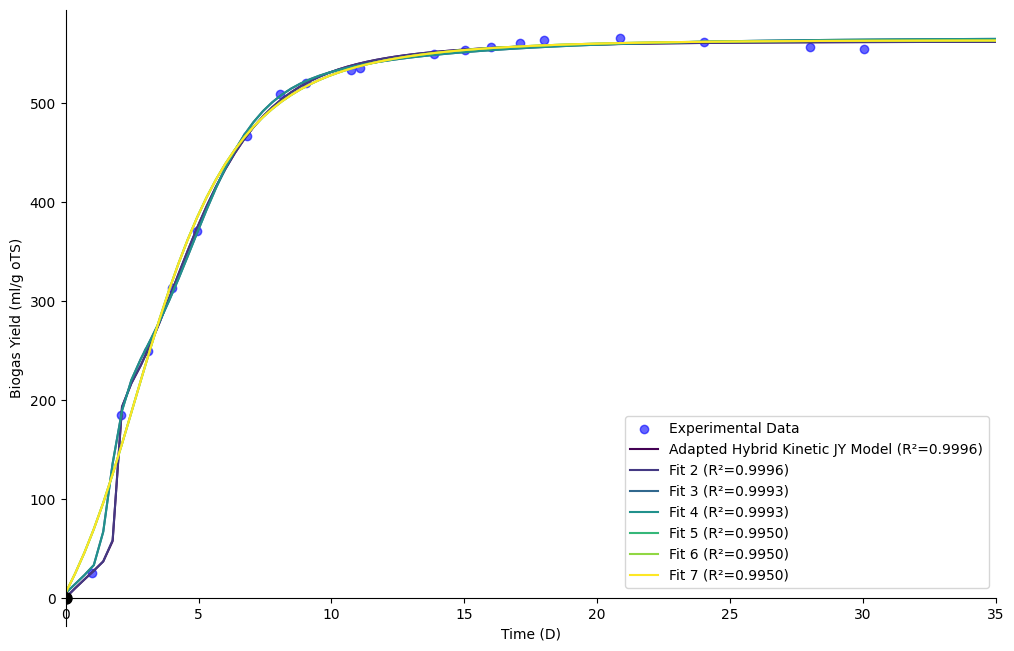

In [ ]:
import matplotlib.pyplot as plt

# Function to plot original data and best fits
def plot_best_fits(t_data, B_data, best_fits, title, dataset_label):
    plt.figure(figsize=(12, 8))
    plt.scatter(t_data, B_data, label='Experimental Data', color='blue', alpha=0.6)

    colors = plt.cm.viridis(np.linspace(0, 1, len(best_fits)))

    # Ensure best_fits is sorted by R-squared descending before plotting
    sorted_fits = sorted(best_fits, key=lambda x: (-x['r2'], x['rmse']))

    # Generate points for plotting the fitted curves up to 35 days
    t_plot = np.linspace(0, 35, 100)

    for i, fit in enumerate(sorted_fits):
        popt = fit['popt']
        B_pred = combined_hybrid_model(t_plot, *popt)
        label = f'Fit {i+1} (R²={fit["r2"]:.4f})'
        if i == 0: # Label the best fit
            label = f'Adapted Hybrid Kinetic JY Model (R²={fit["r2"]:.4f})'
        plt.plot(t_plot, B_pred, label=label, color=colors[i])
        # Remove plotting origin marker within the loop
        # ax = plt.gca() # Get the current axes
        # ax.spines['left'].set_position('zero')
        # ax.spines['bottom'].set_position('zero')

    # Add a single marker and label for the origin
    plt.plot(0, 0, 'o', color='black', markersize=8)

    plt.xlabel('Time (D)')
    plt.ylabel('Biogas Yield (ml/g oTS)')
    # plt.title(title) # Remove the title

    # Adjust legend position to bottom right and slightly above x-axis
    plt.legend(loc='lower right', bbox_to_anchor=(1, 0.05))


    ax = plt.gca() # Get the current axes to set spines to zero
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Extend x-axis limit
    plt.xlim(0, 35)

    plt.grid(False)


    plt.show()
# Plot for HM
plot_best_fits(t_data, B_data_hm, best_fits_hm, 'Combined Hybrid Model Fits for HM Dataset', 'HM')



In [ ]:
# Donwloading file

In [ ]:
# After plotting for HM
plt.savefig('Combined_Hybrid_Model_Fits_HM.tiff', format='tiff', dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import files

# List of files to download
file_names = [
    'Combined_Hybrid_Model_Fits_HM.tiff',
    'Combined_Hybrid_Model_Fits_NHMM.tiff'
]

# Download each file
for file_name in file_names:
    try:
        files.download(file_name)
        print(f"Downloaded: {file_name}")
    except FileNotFoundError:
        print(f"File not found: {file_name}. Please ensure the files were saved correctly.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: Combined_Hybrid_Model_Fits_HM.tiff


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: Combined_Hybrid_Model_Fits_NHMM.tiff
